# Exploratory Spatial Data Analysis: Spatial Autocorrelation

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import libpysal as lps

from splot import esda as esdaplot

## Data

- Number of EV Supply Equipment (EVSE) at each census tract within 15 mintues walk
- Census tract boundary

In [2]:
Walk_Range = pd.read_csv('Data/EVSEdensity_15walk.csv')
Walk_Range['GEOID'] = Walk_Range['GEOID'].astype('str')
## loading census tract for plotting
ct = gpd.read_file('Data/census_tract/ny_census_tract.geojson')
# merge by GEOID
gdf = ct.merge(Walk_Range, on='GEOID')

/Users/joyceyin/anaconda3/lib/python3.11/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 6 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


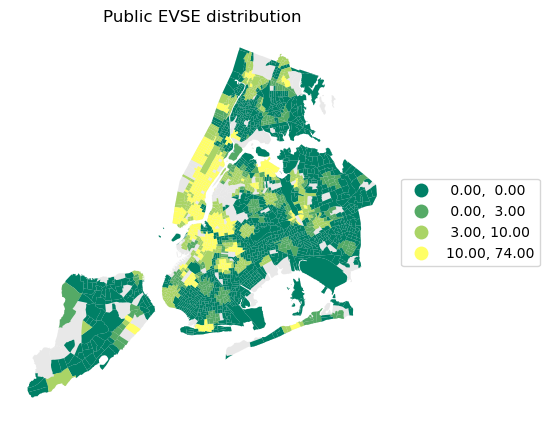

In [4]:
## plot distribution
fig, ax = plt.subplots(figsize = (5,5))

ct.plot(ax=ax, color='lightgrey', alpha=0.5)
ax.set_axis_off()
gdf.plot(ax=ax, column='Walk15_EVSE', scheme="QUANTILES",
    k=6, cmap="summer", legend=True, legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5)})

ax.set_title('Public EVSE distribution')
plt.show()

/var/folders/pn/46n_x6m91tdcfl9d66wj2f3w0000gn/T/ipykernel_81661/1166483486.py:7: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  .plot(ax=ax,column="Walk15_EVSE", color="tomato", alpha=0.5)


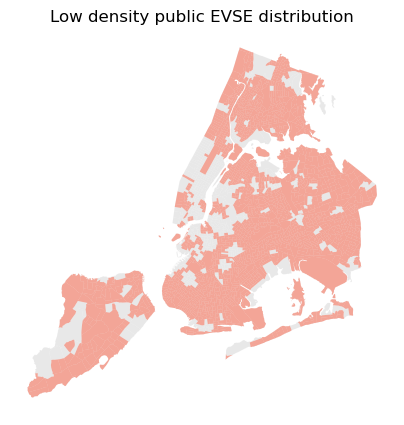

In [7]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize = (5, 5))
ct.plot(ax=ax, color='lightgrey', alpha=0.5)

ax.set_axis_off()

ct.merge(Walk_Range[Walk_Range['Walk15_EVSE']<=10][['GEOID','Walk15_EVSE']], on='GEOID',how="inner")\
    .plot(ax=ax,column="Walk15_EVSE", color="tomato", alpha=0.5)

ax.set_title('Low density public EVSE distribution')
plt.show()

## Sptial Autocorrelation

- Global Moran's I
- Local Moran's I

**Spatial Lag**: The spatially lagged value for a given area is calculated as a weighted average of the neighboring values for that area.

In [25]:
geo_df = gdf

# Generate weight from the GeoDataFrame
w = lps.weights.distance.KNN.from_dataframe(geo_df, k=8)
# Row-standardization
w.transform = "R"

y = geo_df['Walk15_EVSE']

In [26]:
geo_df["lag_EVSE_KNN"] = lps.weights.spatial_lag.lag_spatial(
    w, y
)

/Users/joyceyin/anaconda3/lib/python3.11/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


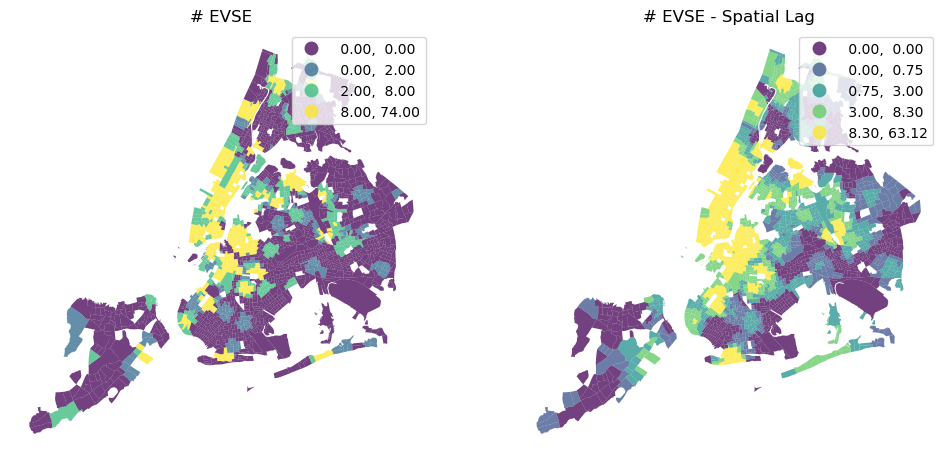

In [27]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axs

geo_df.plot(
    column="Walk15_EVSE",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax1,
)
ax1.set_axis_off()
ax1.set_title("# EVSE")

geo_df.plot(
    column="lag_EVSE_KNN",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax2,
)
ax2.set_axis_off()
ax2.set_title("# EVSE - Spatial Lag")

plt.show()

## Global Autocorrelation

In [19]:
y.median()
yb = y > y.median()  # sum(yb)
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb]
geo_df['yb'] = yb

<Axes: >

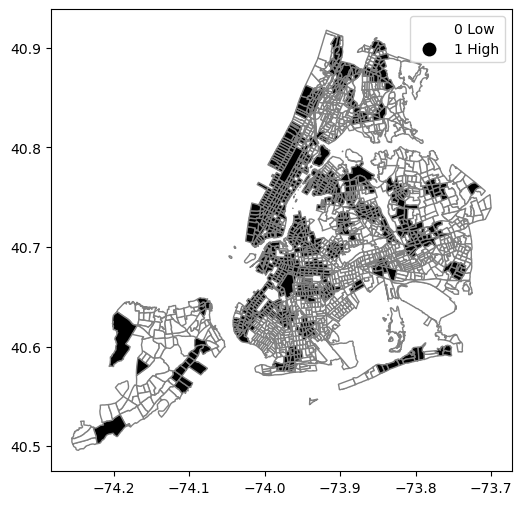

In [28]:
fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'aspect':'equal'})
geo_df.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)

In [29]:
geo_df["EVSE_std"] = y - y.mean()
geo_df["EVSE_lag_std"] = lps.weights.lag_spatial(
    w, y
)

**Moran Scatterplot** : compares EVSE density to it spatial lag EVSE

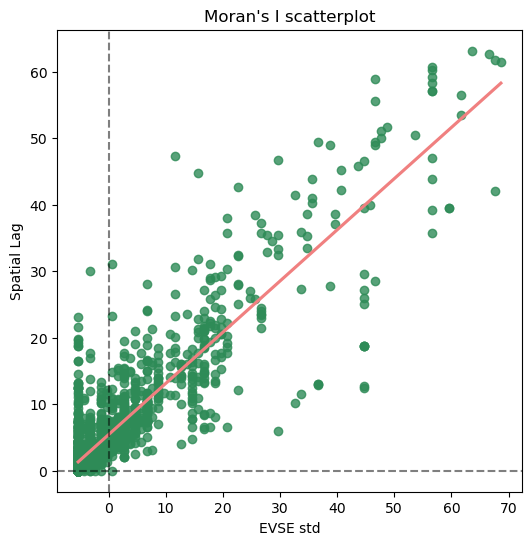

In [30]:
f, ax = plt.subplots(1, figsize=(6, 6))

# red line of best fit using global I as slope

sns.regplot(
    x="EVSE_std",
    y="EVSE_lag_std",
    ci=None,
    data=geo_df,
    color= "seagreen",
    line_kws={"color": "lightcoral"},
)
ax.axvline(0, c="k", alpha=0.5, linestyle="--")
ax.axhline(0, c="k", alpha=0.5, linestyle="--")
ax.set_xlabel("EVSE std")
ax.set_ylabel("Spatial Lag")
ax.set_title("Moran's I scatterplot")
plt.show()

In [32]:
import esda
w.transform = "R"
moran = esda.moran.Moran(geo_df["Walk15_EVSE"], w)

In [37]:
print('The Global Moran revealed a strong positive spatial autocorrelation I = {} \nwith high significance (p={})'.format(moran.I, moran.p_sim))

The Global Moran revealed a strong positive spatial autocorrelation I = 0.7692771331412396 
with high significance (p=0.001)


## Local Spatial Autocorrelation

Gloabl Moran's I first evaluate the existence of spatial autocorrelation,
<br>
then Local Moran's I helps locate the specific cluster (Low-Low, High-High)

**Local indicators of spatial association (LISAs)** extend the Global Moran’s I method by providing a
localized measure of spatial autocorrelation for each census tract

In [39]:
#local moran's
lisa = esda.moran.Moran_Local(geo_df["Walk15_EVSE"], w)

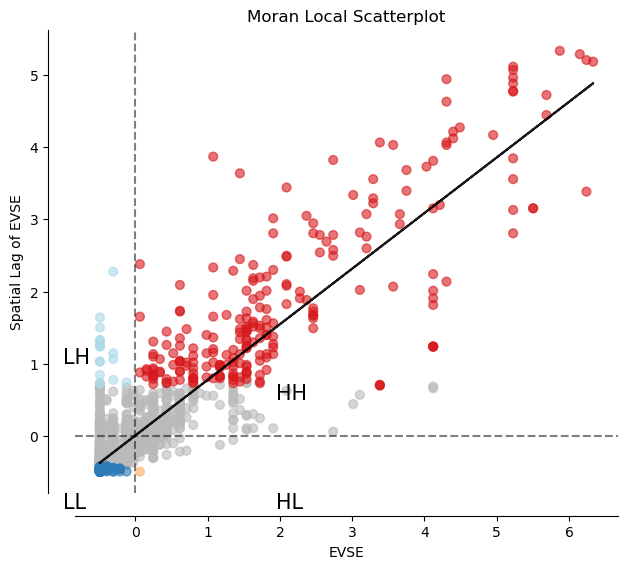

In [50]:
# Plot
fig, ax = esdaplot.moran_scatterplot(lisa, p=0.05)
ax.set_xlabel('EVSE')
ax.set_ylabel('Spatial Lag of EVSE')
plt.text(1.95, 0.5, "HH", fontsize=15)
plt.text(1.95, -1.0, "HL", fontsize=15)
plt.text(-1, 1, "LH", fontsize=15)
plt.text(-1, -1, "LL", fontsize=15)
plt.show()

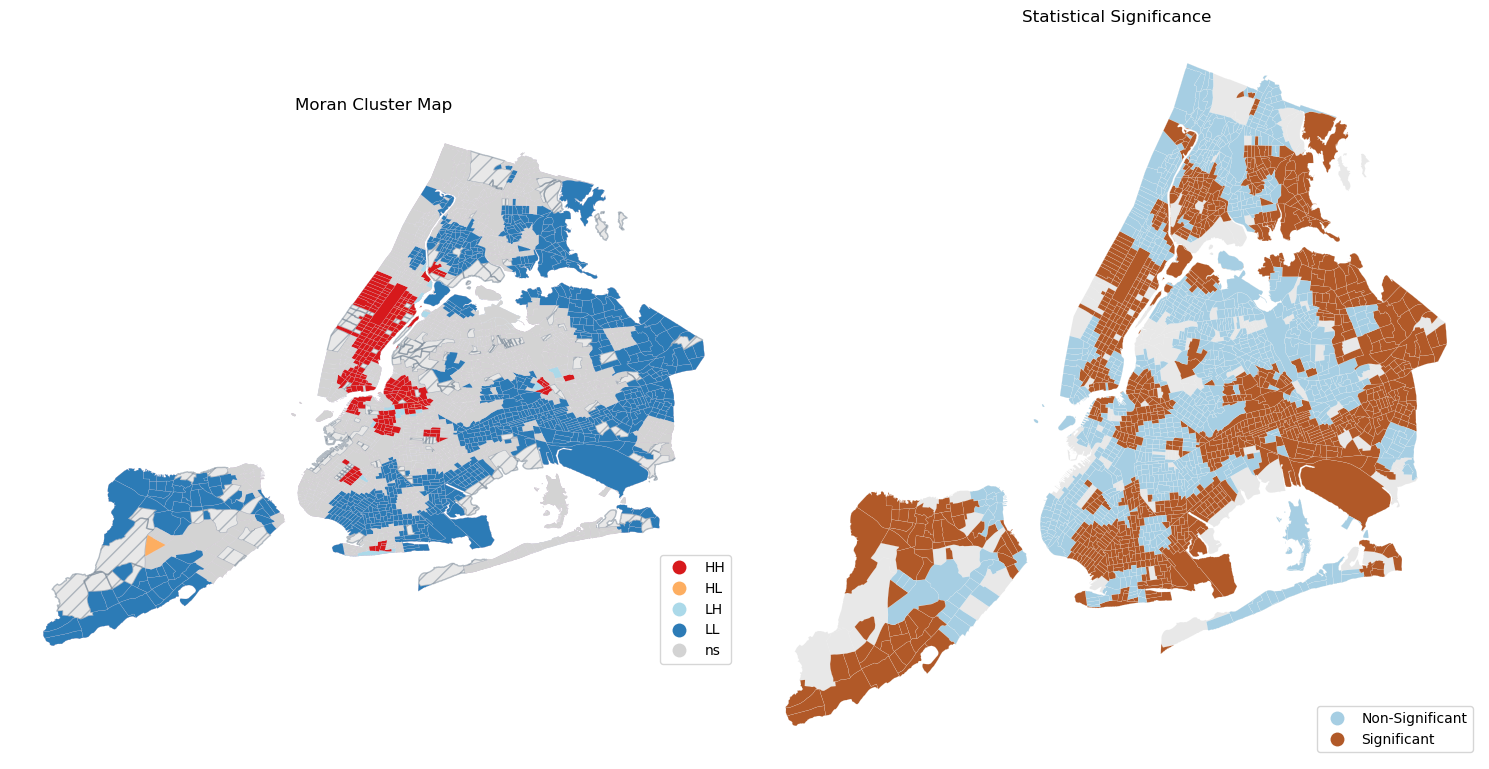

In [42]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 12))


# Subplot 1 #
# Cluster map
ax = axs[0]
ct.merge(geo_df[['GEOID', 'Walk15_EVSE']], on="GEOID", how="left").plot(ax=ax, column="Walk15_EVSE", alpha=0.5,
                                                                        missing_kwds={
                                                                    "color": "lightgrey",
                                                                    "edgecolor": "slategrey",
                                                                    "hatch": "//",
                                                                    "label": "Missing values",
                                                                    },)
# Plot Quadrant colors with 5% significance level 
esdaplot.lisa_cluster(lisa, geo_df, p=0.05, ax=ax, legend_kwds={"loc": "lower right"},)


# Subplot 2 #
# Significance map
ax = axs[1]
# Find out significant observations
ct.plot(ax=ax, color='lightgrey', alpha=0.5)
labels = pd.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=geo_df.index  # Use the index in the original data
).map({1: "Significant", 0: "Non-Significant"})     # Recode 1 to "Significant and 0 to "Non-significant"
# Assign labels to `geo_df` on the fly
geo_df.assign(
    cl=labels
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    legend_kwds={"loc": "lower right"},
    ax=ax,
)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Moran Cluster Map",
            "Statistical Significance",
        ][i]
    )
# Tight layout to minimize in-between white space
f.tight_layout()

# Display the figure
plt.show()